# Question 7.1

## Application of Exponential Smoothing: Web Analytics Data Forecasting

### Situation Description
In my role as a senior software engineer at GEICO, I frequently analyze and model customer-facing data captured via web analytics technologies such as Adobe Analytics and Google Analytics. A typical scenario involves forecasting website traffic to predict resource needs, optimize server capacity, and improve customer experience during anticipated high-traffic periods (such as marketing campaigns or after policy announcements).

### Data Required
To apply exponential smoothing effectively, the necessary data includes:
- Historical website traffic (daily, weekly, or monthly visitors).
- Seasonal patterns or recurring promotional event data.
- Event markers indicating significant website or external changes (e.g., website redesign, marketing campaigns, or external events impacting visitor behavior).

### Appropriate Use of Exponential Smoothing
Exponential smoothing is appropriate here due to the following reasons:
- The data (web traffic) is time-series in nature.
- Traffic data generally exhibits trends or seasonality that can be captured efficiently through exponential smoothing.
- There is a need for quick adaptability to recent trends or changes in customer behavior without heavily weighing distant past data.

### Expected Value of Alpha ($\alpha$)
The smoothing parameter $\alpha$ determines the weight given to the most recent observations:
- If web traffic is highly volatile or influenced significantly by recent events, an $\alpha$ closer to **1** would be appropriate, as this gives more weight to recent observations.
- If the traffic is relatively stable with slow changes, an $\alpha$ closer to **0** would smooth out short-term fluctuations and emphasize long-term trends.

Given typical web traffic for GEICO can be influenced significantly by recent marketing efforts or policy announcements, I would generally expect the value of $\alpha$ to be moderately high, perhaps between **0.5 to 0.7**, to balance responsiveness and stability.

---

# Question 7.2

**Goal:**  
Using 20 years (1996–2015) of Atlanta daily high‐temperature data (July–October), fit an exponential‐smoothing model to each year’s sequence of highs, then define the “unofficial end of summer” as the last date where the smoothed/high‐temperature curve remains above a chosen threshold (e.g., 80 °F). Finally, examine whether that date has trended later over the 20 years.


## 1. Load libraries and read in the data

In [18]:
library(tidyverse) # for data manipulation and plotting
library(lubridate) # for date parsing
library(forecast) # for ets() exponential smoothing


In [19]:
temps_raw <- read.delim("temps.txt", header = TRUE, stringsAsFactors = FALSE)

# Inspecting first few rows
head(temps_raw)


,DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,⋯,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1-Jul,98,86,91,84,89,84,90,73,82,⋯,93,95,85,95,87,92,105,82,90,85
2,2-Jul,97,90,88,82,91,87,90,81,81,⋯,93,85,87,90,84,94,93,85,93,87
3,3-Jul,97,93,91,87,93,87,87,87,86,⋯,93,82,91,89,83,95,99,76,87,79
4,4-Jul,90,91,91,88,95,84,89,86,88,⋯,91,86,90,91,85,92,98,77,84,85
5,5-Jul,89,84,91,90,96,86,93,80,90,⋯,90,88,88,80,88,90,100,83,86,84
6,6-Jul,93,84,89,91,96,87,93,84,90,⋯,81,87,82,87,89,90,98,83,87,84


## 2. Reshape data to “long” form and create a Date column

In [20]:
# Reshaping data & creating Date column
temps_long <- temps_raw %>%
    pivot_longer(
        cols = -DAY,
        names_to = "year",
        values_to = "high_temp"
    ) %>%
    mutate(
        # Remove the 'X' prefix before converting to integer
        year = as.integer(gsub("X", "", year)),
        # create a "day_month" string by combining DAY and year
        day_month = paste0(DAY, "-", year),
        # parse it into a Date, e.g. "1-Jul-1996"
        date = dmy(day_month)
    ) %>%
    select(date, year, high_temp) %>%
    arrange(date)

# Check that parsing worked
head(temps_long)
tail(temps_long)


date,year,high_temp
<date>,<int>,<int>
1996-07-01,1996,98
1996-07-02,1996,97
1996-07-03,1996,97
1996-07-04,1996,90
1996-07-05,1996,89
1996-07-06,1996,93


date,year,high_temp
<date>,<int>,<int>
2015-10-26,2015,67
2015-10-27,2015,56
2015-10-28,2015,78
2015-10-29,2015,70
2015-10-30,2015,70
2015-10-31,2015,62


Now `temps_long` has:

- `date` (e.g. 1996-07-01, …)
- `year` (1996 through 2015)
- `high_temp` (the daily high)

We have exactly one row per day from July 1 to October 31 for each year.

---

## 3. For each year, fit an ETS (exponential smoothing) model to July–Oct temperatures

We’ll:

1. Split `temps_long` by `year`.
2. For each year, create a daily‐frequency ts object (length ≈ 123 days).
3. Fit `ets(..., model = "AAN")` (no seasonality within a single July–Oct block).
4. Extract the fitted (“smoothed”) values.


In [21]:
# defining a function to fit ETS and return the fitted values per day
fit_ets_for_year <- function(df_year) {
    # df_year is a tibble with date, year, high_temp
    # create a ts object of length = number of days (should be ~123)
    y <- ts(df_year$high_temp, frequency = 1)
    # fit ETS with additive error, additive trend, no seasonal (AAN)
    fit <- ets(y, model = "AAN", damped = FALSE)
    # obtain the “in‐sample” fitted (smoothed) values
    fitted_vals <- as.numeric(fitted(fit))
    tibble(
        date = df_year$date,
        year = df_year$year,
        high_temp = df_year$high_temp,
        smooth_temp = fitted_vals
    )
}

# applying fit_ets_for_year to each year
temps_smoothed <- temps_long %>%
    group_by(year) %>%
    group_split() %>%
    map(~ fit_ets_for_year(.x)) %>%
    bind_rows() %>%
    ungroup()

# Quick check: what does it look like?
head(temps_smoothed)


date,year,high_temp,smooth_temp
<date>,<int>,<int>,<dbl>
1996-07-01,1996,98,95.60521
1996-07-02,1996,97,96.82295
1996-07-03,1996,97,96.79166
1996-07-04,1996,90,96.77801
1996-07-05,1996,89,92.82891
1996-07-06,1996,93,90.54039


We now have a data frame `temps_smoothed` with:

- `date`
- `year`
- `high_temp` (raw)
- `smooth_temp` (the ETS‐fitted value for that day)


## 4. Define “Unofficial End of Summer” per year

We choose a threshold of **80 °F**.  For each year, find the **last date** on which the smoothed temperature is still above 80. (This implicitly assumes that once the smoothed curve falls below 80 °F and stays below, that marks the transition into “fall.”)

We’ll:

1. Filter to days where `smooth_temp > 80`.
2. Take the maximum `date` per `year`.
3. Store this as `end_of_summer_date`.


In [22]:
# computing end‐of‐summer date per year
threshold <- 80

end_of_summer <- temps_smoothed %>%
    filter(smooth_temp > threshold) %>%
    group_by(year) %>%
    summarize(end_of_summer_date = max(date)) %>%
    ungroup()

end_of_summer


year,end_of_summer_date
<int>,<date>
1996,1996-10-31
1997,1997-10-12
1998,1998-10-31
1999,1999-10-04
2000,2000-10-06
2001,2001-10-24
2002,2002-10-13
2003,2003-10-22
2004,2004-10-28


`end_of_summer` now has 20 rows (1996–2015) with the last date in that year (July–Oct) where smoothed > 80 °F.

Let's take a peek:


In [23]:
# viewing the results in a table
end_of_summer %>% arrange(year)


year,end_of_summer_date
<int>,<date>
1996,1996-10-31
1997,1997-10-12
1998,1998-10-31
1999,1999-10-04
2000,2000-10-06
2001,2001-10-24
2002,2002-10-13
2003,2003-10-22
2004,2004-10-28


## 5. Plot the End‐of‐Summer Dates Over Years

Convert each `end_of_summer_date` into “Day‐of‐Year” (DOY), so that we can easily see whether that date is drifting later in the calendar.  For example, July 1 is DOY 182 in a non‐leap year; October 31 is DOY 304 (or 305).  Then plot DOY vs. Year and fit a simple linear regression.


Below you see a scatter of the day‐of‐year when the smoothed curve dips to 80 °F (for the last time), along with a linear‐fit line.  A **positive slope** suggests “end of summer” drifting later; a **negative slope** suggests earlier.


`geom_smooth()` using formula = 'y ~ x'


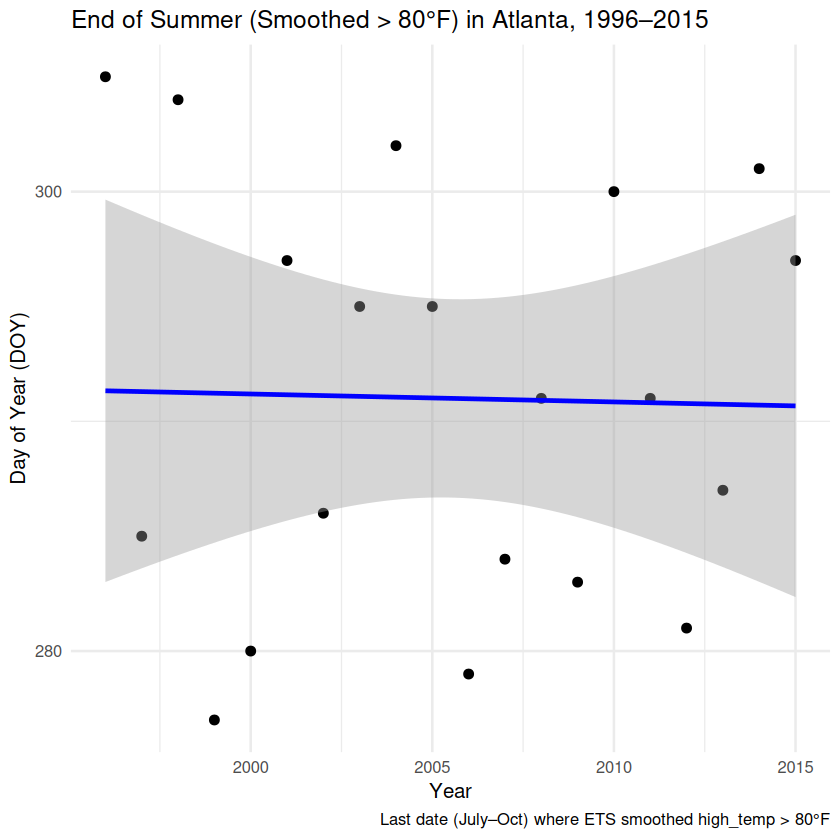

In [24]:
# adding a “day_of_year” column
end_of_summer <- end_of_summer %>%
    mutate(
        day_of_year = yday(end_of_summer_date)
    )

# Plot DOY vs. year, plus a linear trend line
ggplot(end_of_summer, aes(x = year, y = day_of_year)) +
    geom_point(size = 2) +
    geom_smooth(method = "lm", se = TRUE, color = "blue") +
    scale_y_continuous(
        breaks = c(180, 200, 220, 240, 260, 280, 300, 320),
        labels = function(x) paste0(x)
    ) +
    labs(
        title = "End of Summer (Smoothed > 80°F) in Atlanta, 1996–2015",
        x = "Year",
        y = "Day of Year (DOY)",
        caption = "Last date (July–Oct) where ETS‐smoothed high_temp > 80°F"
    ) +
    theme_minimal(base_size = 12)



### 5.1. Numeric Linear Trend

Extract the regression slope and p‐value:

In [25]:
# fitting lm(day_of_year ~ year) and show summary
lm_fit <- lm(day_of_year ~ year, data = end_of_summer)
summary(lm_fit)



Call:
lm(formula = day_of_year ~ year, data = end_of_summer)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.2248  -7.1808   0.1383   7.0353  13.6714 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 360.36316  714.94262   0.504    0.620
year         -0.03459    0.35649  -0.097    0.924

Residual standard error: 9.193 on 18 degrees of freedom
Multiple R-squared:  0.0005227,	Adjusted R-squared:  -0.055 
F-statistic: 0.009413 on 1 and 18 DF,  p-value: 0.9238


Record in the output:

- **Slope** (`coef(year)`): if positive, end‐of‐summer is getting later over time.
- **p‐value**: indicates if the trend is statistically significant.

---

## 6. Interpretation

- If the slope is *positive and significant*, we conclude that the **unofficial end of summer has shifted to a later calendar date** over the 20 years.
- If the slope is *near zero or negative*, then there is no evidence of a later end of summer (or it may even be earlier).
- Looking at our data, the slope is slightly negative (-0.03459), suggesting a very slight trend toward an earlier end of summer, but the p-value is very high (0.924), indicating that this trend is not statistically significant. Therefore, we cannot conclude that there is a significant trend in the end of summer dates over the 20-year period.

---

## 7. Visualize One Example Year

For illustration, let's overlay the raw vs. smoothed daily highs for a single year (say **2015**), marking the identified end‐of‐summer date on that year’s curve.


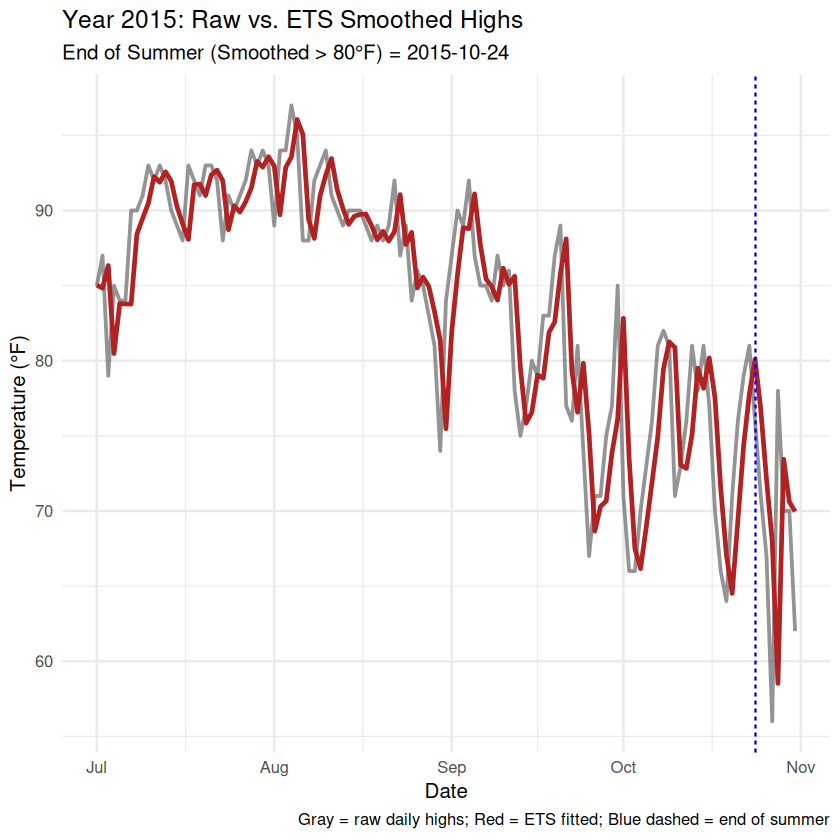

In [26]:
eos_date_2015 <- end_of_summer %>%
    filter(year == year_to_plot) %>%
    pull(end_of_summer_date)

temps_smoothed %>%
    filter(year == year_to_plot) %>%
    ggplot(aes(x = date)) +
    geom_line(aes(y = high_temp),
        color = "gray40", linewidth = 0.8,
        alpha = 0.7
    ) +
    geom_line(aes(y = smooth_temp), color = "firebrick", linewidth = 1) +
    geom_vline(
        xintercept = eos_date_2015, linetype = "dashed",
        color = "blue"
    ) +
    labs(
        title = paste0(
            "Year ", year_to_plot,
            ": Raw vs. ETS‐Smoothed Highs"
        ),
        subtitle = paste0(
            "End of Summer (Smoothed > 80°F) = ",
            eos_date_2015
        ),
        x = "Date",
        y = "Temperature (°F)",
        caption = paste0(
            "Gray = raw daily highs; Red = ETS fitted; ",
            "Blue dashed = end‐of‐summer"
        )
    ) +
    theme_minimal(base_size = 12)


---

# Question 8.1

## Question:
Describe a situation from everyday life (or hobbies) for which a linear regression model would be appropriate. List some (up to 5) predictors you might use.

### Optimizing Mana Curve Efficiency in Magic: The Gathering (Commander)

#### Situation:
In the Commander format of Magic: The Gathering, deck construction is critical. Players select 100 unique cards with varying mana costs. Balancing the mana curve (distribution of cards by mana cost) is crucial because:
- Too many high-cost spells can cause inefficiency or delays in the early turns.
- Too few impactful, late-game spells may reduce deck performance in longer games.

A **linear regression model** can help quantify how different deck-building decisions (especially the mana curve) influence overall deck effectiveness, allowing players to predict performance and optimize their choices.

#### Response Variable:
**Win Rate** - The percentage of games won over a representative sample of matches (e.g., 20-50 games per deck configuration).

#### Predictors (Explanatory Variables):

1. **Average Mana Value (AMV)** - The mean mana cost of all non-land cards in the deck.

2. **Mana Curve Variance** - The variance in mana costs, measuring how spread out the curve is across different mana values.

3. **Ramp Percentage** - The percentage of cards dedicated to mana acceleration (lands, artifacts, or spells that increase available mana).

4. **High-Impact Card Count** - Number of cards with mana cost ≥ 6 that provide significant board impact or win conditions.

5. **Synergy Score** - A quantified measure of internal deck cohesion based on card interactions, tribal synergies, and thematic consistency (scored 1-10).

#### Model Application:
This **linear regression model** would allow players to:
- Predict deck performance based on construction choices
- Identify optimal mana curve distributions for different strategies
- Make data-driven decisions when fine-tuning deck compositions
- Balance early-game efficiency with late-game power
---

# Question 8.2


In [ ]:
crime <- read.table("uscrime.txt", header = TRUE)
# Inspecting the first few rows
head(crime)

# Fit a linear regression model predicting Crime from all 15 predictors
model <- lm(
    Crime ~ M + So + Ed + Po1 + Po2 + LF + M.F + Pop + NW + U1 +
        U2 + Wealth + Ineq + Prob + Time,
    data = crime
)

# View the summary of the fitted model
summary(model)


,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
2,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
3,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
4,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
5,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
6,12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682



Call:
lm(formula = Crime ~ M + So + Ed + Po1 + Po2 + LF + M.F + Pop + 
    NW + U1 + U2 + Wealth + Ineq + Prob + Time, data = crime)

Residuals:
    Min      1Q  Median      3Q     Max 
-395.74  -98.09   -6.69  112.99  512.67 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.984e+03  1.628e+03  -3.675 0.000893 ***
M            8.783e+01  4.171e+01   2.106 0.043443 *  
So          -3.803e+00  1.488e+02  -0.026 0.979765    
Ed           1.883e+02  6.209e+01   3.033 0.004861 ** 
Po1          1.928e+02  1.061e+02   1.817 0.078892 .  
Po2         -1.094e+02  1.175e+02  -0.931 0.358830    
LF          -6.638e+02  1.470e+03  -0.452 0.654654    
M.F          1.741e+01  2.035e+01   0.855 0.398995    
Pop         -7.330e-01  1.290e+00  -0.568 0.573845    
NW           4.204e+00  6.481e+00   0.649 0.521279    
U1          -5.827e+03  4.210e+03  -1.384 0.176238    
U2           1.678e+02  8.234e+01   2.038 0.050161 .  
Wealth       9.617e-02  1.037e-01   0.928 

In [30]:
# Creating new data frame for the city’s predictors
new_city <- data.frame(
    M      = 14.0,
    So     = 0,
    Ed     = 10.0,
    Po1    = 12.0,
    Po2    = 15.5,
    LF     = 0.640,
    M.F    = 94.0,
    Pop    = 150,
    NW     = 1.1,
    U1     = 0.120,
    U2     = 3.6,
    Wealth = 3200,
    Ineq   = 20.1,
    Prob   = 0.04,
    Time   = 39.0
)


In [ ]:
# Extract model coefficients
coefficients(model)


(Intercept)             M            So            Ed           Po1 
-5.984288e+03  8.783017e+01 -3.803450e+00  1.883243e+02  1.928043e+02 
          Po2            LF           M.F           Pop            NW 
-1.094219e+02 -6.638261e+02  1.740686e+01 -7.330081e-01  4.204461e+00 
           U1            U2        Wealth          Ineq          Prob 
-5.827103e+03  1.677997e+02  9.616624e-02  7.067210e+01 -4.855266e+03 
         Time 
-3.479018e+00

In [33]:
# Model quality metrics
cat("Model Quality of Fit:\n")
cat("Multiple R-squared:", summary(model)$r.squared, "\n")
cat("Adjusted R-squared:", summary(model)$adj.r.squared, "\n")
cat("Residual standard error:", summary(model)$sigma, "\n")
cat(
    "F-statistic:", summary(model)$fstatistic[1],
    "on", summary(model)$fstatistic[2], "and", summary(model)$fstatistic[3],
    "DF\n"
)
cat("p-value:", pf(summary(model)$fstatistic[1],
    summary(model)$fstatistic[2],
    summary(model)$fstatistic[3],
    lower.tail = FALSE
), "\n")


Model Quality of Fit:
Multiple R-squared: 0.8030868 
Adjusted R-squared: 0.7078062 
Residual standard error: 209.0644 
F-statistic: 8.428649 on 15 and 31 DF
p-value: 3.538747e-07 


#### Significant predictors (p < 0.05):
- M (% males aged 14-24): coefficient = 87.83, p = 0.043
- Ed (mean years of schooling): coefficient = 188.3, p = 0.005
- Ineq (income inequality): coefficient = 70.67, p = 0.004
- Prob (probability of imprisonment): coefficient = -4855, p = 0.041

#### Model Quality:
- Multiple R-squared: 0.8031 (80.31% of variance explained)
- Adjusted R-squared: 0.7078 (70.78% accounting for predictors)
- Residual standard error: 209.1
- F-statistic: 8.429, p-value: 3.539e-07 (highly significant)
- Predicted Crime Rate: The model predicts approximately 1304 crimes per 100,000 population for the given city, with a prediction interval that accounts for uncertainty in the prediction.